In [22]:
import pandas as pd
import os
from datetime import datetime, timedelta
import statistics
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv(os.path.join("data","TG_STAID002759.txt"), names = ['souid', 'date', 'tg', 'q_tg'], 
                 header=0 )

In [24]:
df

,souid,date,tg,q_tg
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53046,111448,20210327,69,0
53047,111448,20210328,77,0
53048,111448,20210329,144,0
53049,111448,20210330,149,0


In [25]:
df['date'] = df['date'].astype(str)
df['date']= pd.to_datetime(df['date'])

In [26]:
df = df.set_index('date')

In [27]:
# Checking for gaps in the time series
(df.index.to_series().diff()> pd.Timedelta(days=1)).value_counts()

False    53051
Name: date, dtype: int64

In [28]:
temp = df.index.to_series().diff() > pd.Timedelta(days=1)

In [29]:
df.index.to_series().diff().sort_values()

date
1876-01-02   1 days
1972-10-25   1 days
1972-10-26   1 days
1972-10-27   1 days
1972-10-28   1 days
              ...  
1924-06-07   1 days
1924-06-08   1 days
1924-05-29   1 days
2021-03-31   1 days
1876-01-01      NaT
Name: date, Length: 53051, dtype: timedelta64[ns]

In [30]:
#I interpolate the temperature data where they are missing (code -9999) using the avg() of the previous
#and following year
df['q_tg'].astype(int)
bad_data_index = df[df['q_tg']==9 ].index.tolist()

for index in bad_data_index:
    yb = datetime(index.year - 1, index.month, index.day)
    yf = datetime(index.year + 1, index.month, index.day)
    temp_yb = df.at[yb,'tg']
    temp_yf = df.at[yf,'tg']
    repl_val = statistics.mean([temp_yb,temp_yf])
    df.at[index, 'tg'] = repl_val

In [31]:
#Dividing the temperature column by 10 to get Celsius not 0.1 C
df['tg'] = df['tg']/10

In [32]:
#Dropping the data quality control as not helpful anymore
df.drop('q_tg', axis=1, inplace=True)

In [33]:
df

,souid,tg
date,,
1876-01-01,127488,2.2
1876-01-02,127488,2.5
1876-01-03,127488,0.3
1876-01-04,127488,-5.8
1876-01-05,127488,-9.8
...,...,...
2021-03-27,111448,6.9
2021-03-28,111448,7.7
2021-03-29,111448,14.4


In [34]:
temp_series = df['tg']

In [35]:
pip install cydets

Note: you may need to restart the kernel to use updated packages.


In [36]:
from cydets.algorithm import detect_cycles

In [37]:
cycles = detect_cycles(temp_series)

In [38]:
ten_year_cycles = cycles[cycles['duration']>='3650 days'].sort_values('duration')

In [39]:
ten_year_cycles

,t_start,t_end,t_minimum,doc,duration
9367,1984-07-11,1994-08-01,1987-01-13,0.913371,3673 days
3511,1917-06-20,1928-07-16,1922-01-26,0.760829,4044 days
1,1876-01-01,1887-07-31,1876-12-24,0.340866,4229 days
5841,1943-08-02,1959-07-11,1956-02-01,0.871940,5822 days
10262,1994-08-01,2010-07-12,2006-01-23,0.866290,5824 days
7237,1959-07-11,1976-07-17,1969-12-21,0.849341,6216 days
2478,1905-07-01,1928-07-16,1917-02-04,0.822976,8416 days
7238,1959-07-11,1984-07-11,1978-12-31,0.896422,9132 days
2,1876-01-01,1905-07-01,1893-01-18,0.389831,10773 days
3,1876-01-01,2010-07-12,1929-02-10,0.467043,49135 days


In [40]:
df1 = df.reset_index()

In [41]:
df1.drop('souid', axis=1)

,date,tg
0,1876-01-01,2.2
1,1876-01-02,2.5
2,1876-01-03,0.3
3,1876-01-04,-5.8
4,1876-01-05,-9.8
...,...,...
53046,2021-03-27,6.9
53047,2021-03-28,7.7
53048,2021-03-29,14.4
53049,2021-03-30,14.9


In [42]:
df1.rename(columns = {'date' : 'ds', 'tg' : 'y'}, inplace = True)

In [43]:
m = Prophet()
m.fit(df1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
future = m.make_future_dataframe(periods=30)

In [45]:
future.tail()

,ds
53076,2021-04-26
53077,2021-04-27
53078,2021-04-28
53079,2021-04-29
53080,2021-04-30


In [46]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,1876-01-01,0.316007,-4.619116,5.038522
1,1876-01-02,0.308157,-4.735414,5.055089
2,1876-01-03,0.320138,-4.630244,5.383054
3,1876-01-04,0.229869,-4.385211,5.142697
4,1876-01-05,0.201491,-4.705618,4.884556
...,...,...,...,...
53076,2021-04-26,12.392200,7.736171,17.443265
53077,2021-04-27,12.515338,7.790790,17.408023
53078,2021-04-28,12.698465,8.224129,17.571067
53079,2021-04-29,12.823928,8.344381,17.653579


In [47]:
forecast_april = forecast.tail(5)

In [48]:
cols = ['ds','yhat_lower', 'yhat_upper','yhat']
plot_df = forecast_april[cols]

In [49]:
plot_df.dtypes

ds            datetime64[ns]
yhat_lower           float64
yhat_upper           float64
yhat                 float64
dtype: object

In [50]:
plot_df.index

RangeIndex(start=53076, stop=53081, step=1)

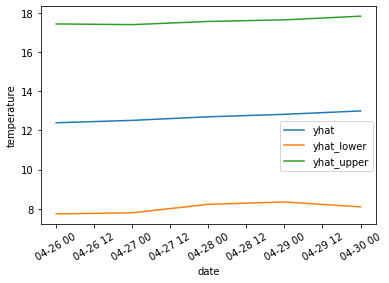

In [51]:
fig, ax = plt.subplots()
sns.lineplot(plot_df['ds'],y=plot_df['yhat'], label='yhat')
sns.lineplot(plot_df['ds'],plot_df['yhat_lower'], label='yhat_lower')
sns.lineplot(plot_df['ds'],plot_df['yhat_upper'], label='yhat_upper')
plt.xticks(rotation=30) # rotates the x axis titles by 30 degrees
plt.xlabel('date')
plt.ylabel('temperature')
plt.legend()
leg = plt.legend( loc = 'upper right')
plt.legend(bbox_to_anchor = [0.7, 0.22]);